In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from glob import glob
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# Set parameters
IMAGE_SIZE = (224, 224)

In [4]:
print(len(os.listdir("/content/drive/MyDrive/masks_dataset")))

6000


In [5]:
train_files = []
mask_files = glob('/content/drive/MyDrive/masks_dataset/*_mask*')
for i in mask_files:
     train_files.append(i.replace('_mask', ''))

In [6]:
len(train_files)

3000

In [7]:
df = pd.DataFrame({"image_path": train_files, "mask_path":mask_files})

def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value:
        return 1
    else:
        return 0

df['mask'] = df["mask_path"].apply(lambda x: diagnosis(x))


In [8]:
df.head()

,image_path,mask_path,mask
0,/content/drive/MyDrive/masks_dataset/y549.jpg,/content/drive/MyDrive/masks_dataset/y549_mask...,1
1,/content/drive/MyDrive/masks_dataset/y55.jpg,/content/drive/MyDrive/masks_dataset/y55_mask.jpg,1
2,/content/drive/MyDrive/masks_dataset/y550.jpg,/content/drive/MyDrive/masks_dataset/y550_mask...,1
3,/content/drive/MyDrive/masks_dataset/y551.jpg,/content/drive/MyDrive/masks_dataset/y551_mask...,1
4,/content/drive/MyDrive/masks_dataset/y552.jpg,/content/drive/MyDrive/masks_dataset/y552_mask...,1


In [9]:
df['mask'].value_counts()

1    1500
0    1500
Name: mask, dtype: int64

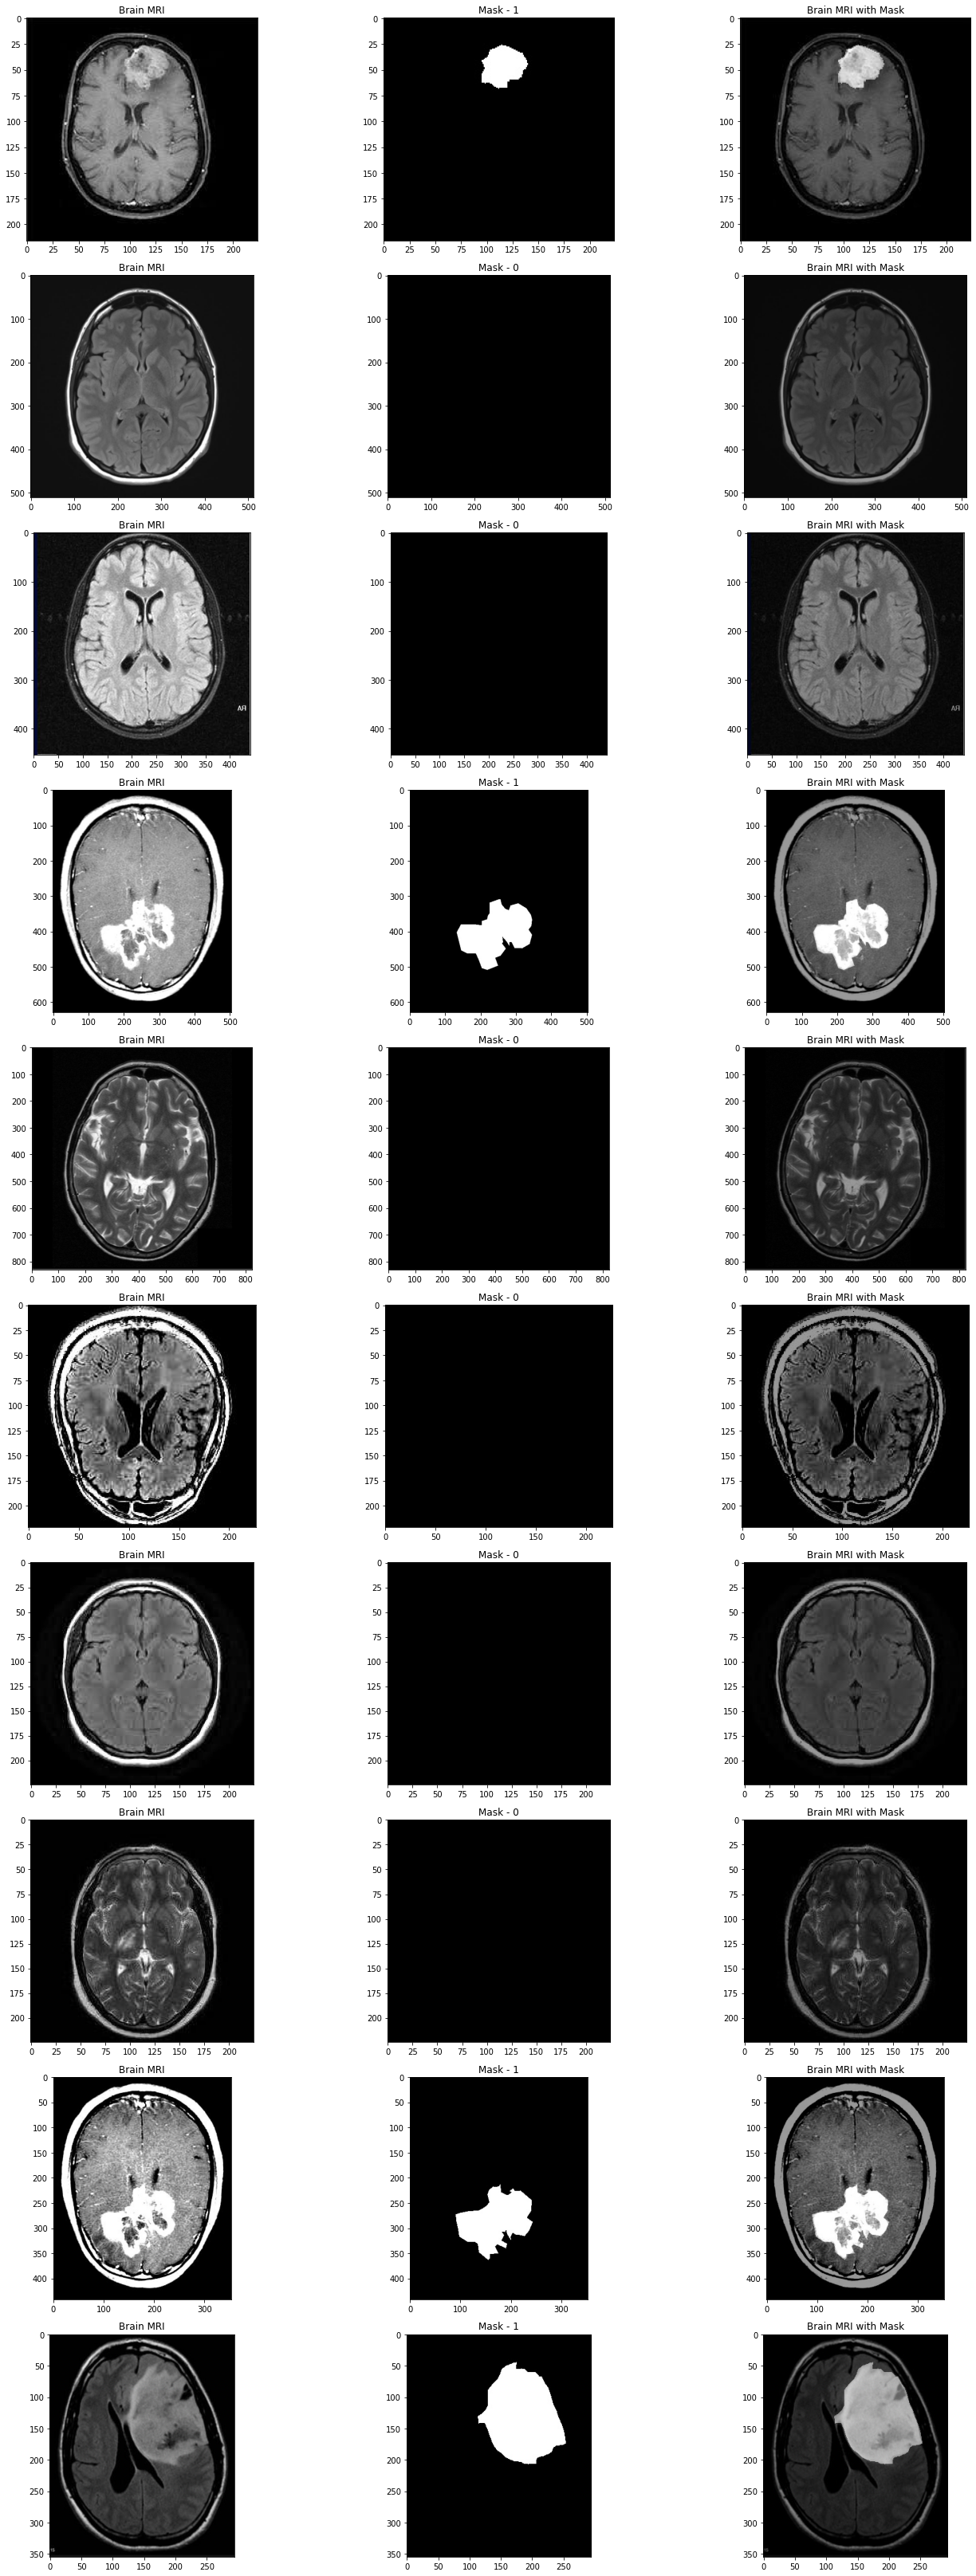

In [10]:
fig, ax = plt.subplots(10,3,figsize=(20,45))
for x in range(10):
    i = random.randint(0, len(df))
    img = cv2.imread(df['image_path'][i])
    mask = cv2.imread(df['mask_path'][i])
    ax[x][0].title.set_text("Brain MRI")
    ax[x][0].imshow(img)
    ax[x][1].title.set_text("Mask - " + str(df['mask'][i]))
    ax[x][1].imshow(mask)
    ax[x][2].title.set_text("Brain MRI with Mask")
    ax[x][2].imshow(img)
    ax[x][2].imshow(mask, alpha=0.4)
plt.tight_layout()

In [11]:
df['mask'] = df['mask'].apply(lambda x: str(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3000 non-null   object
 1   mask_path   3000 non-null   object
 2   mask        3000 non-null   object
dtypes: object(3)
memory usage: 70.4+ KB


In [12]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2167, 3)
(383, 3)
(450, 3)


In [13]:
datagen = ImageDataGenerator(rescale=1/255.)
train_generator = datagen.flow_from_dataframe(df_train, 
                                             x_col='image_path',
                                             y_col='mask',
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=True,
                                             target_size=IMAGE_SIZE)
validation_generator = datagen.flow_from_dataframe(df_val,
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=32,
                                                  shuffle=True,
                                                  target_size=IMAGE_SIZE)
test_generator = datagen.flow_from_dataframe(df_test,
                                            x_col='image_path',
                                            y_col='mask',
                                            class_mode='categorical',
                                            batch_size=32,
                                            shuffle=False,
                                            target_size=IMAGE_SIZE)

Found 2167 validated image filenames belonging to 2 classes.
Found 383 validated image filenames belonging to 2 classes.
Found 450 validated image filenames belonging to 2 classes.


In [14]:
base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
# for layer in base_model.layers:
#     layer.trainable = False

x = base_model.output
x = AveragePooling2D(pool_size=(4,4))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(2, activation='softmax')(x)

model = Model(base_model.input, outputs=x)
model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

In [15]:
es = EarlyStopping(monitor='val_loss',
                  mode='min',
                  verbose=1,
                  patience=10)
checkpoint = ModelCheckpoint(filepath='clf_model_resnet50.hdf5',
                            verbose=1,
                            save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             mode='min',
                             verbose=1,
                             patience=5,
                             min_denta=0.0001,
                             factor=0.2)
my_callbacks = [es, checkpoint, reduce_lr]

In [16]:
history = model.fit(train_generator,
                   epochs=30,
                   steps_per_epoch= train_generator.n // train_generator.batch_size,
                   validation_data=validation_generator,
                   validation_steps = validation_generator.n // validation_generator.batch_size,
                   callbacks=[checkpoint, es])

Epoch 1/30
67/67 [==============================] - 502s 7s/step - loss: 0.4158 - accuracy: 0.8333 - val_loss: 9.0214 - val_accuracy: 0.4886

Epoch 00001: val_loss improved from inf to 9.02144, saving model to clf_model_resnet50.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
67/67 [==============================] - 47s 704ms/step - loss: 0.2347 - accuracy: 0.9171 - val_loss: 11.3668 - val_accuracy: 0.4972

Epoch 00002: val_loss did not improve from 9.02144
Epoch 3/30
67/67 [==============================] - 47s 704ms/step - loss: 0.1134 - accuracy: 0.9644 - val_loss: 29.7045 - val_accuracy: 0.4972

Epoch 00003: val_loss did not improve from 9.02144
Epoch 4/30
67/67 [==============================] - 47s 704ms/step - loss: 0.1052 - accuracy: 0.9593 - val_loss: 0.7058 - val_accuracy: 0.4943

Epoch 00004: val_loss improved from 9.02144 to 0.70584, saving model to clf_model_resnet50.hdf5
Epoch 5/30
67/67 [==============================] - 47s 704ms/step - loss: 0.0727 - accuracy: 0.9780 - val_loss: 1.9631 - val_accuracy: 0.4517

Epoch 00005: val_loss did not improve from 0.70584
Epoch 6/30
67/67 [==============================] - 47s 704ms/step - loss: 0.0954 - accuracy: 0.9700 - val_loss: 3.5753 - val_accuracy: 0.4972

Epoch 00006: val_loss did not

In [17]:
model.save("/content/drive/MyDrive/Soumaya - PFE/masks_models/clf_model_resnet50")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Soumaya - PFE/masks_models/clf_model_resnet50/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [18]:
model.evaluate(test_generator)

15/15 [==============================] - 80s 6s/step - loss: 0.0784 - accuracy: 0.9822


[0.07836456596851349, 0.9822221994400024]